In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import theano
import numpy as np
import matplotlib.pyplot as plt
from gp import GaussianProcess, RBFKernel

In [3]:
debug = True
if debug:
    theano.config.mode = "FAST_COMPILE"
    theano.config.optimizer = "fast_compile"
    theano.config.exception_verbosity = "high"
else:
    theano.config.mode = "FAST_RUN"
    theano.config.optimizer = "fast_run"

In [4]:
def secret_function(x):
    return np.sin(x)

In [5]:
def as_shared(x, name, borrow=True):
    return theano.shared(value=x, name=name, borrow=borrow)

In [6]:
# Training data.
X = as_shared(np.random.uniform(-3, 3, 10).reshape(-1, 1), "X")
Y = as_shared(secret_function(X.get_value()), "Y")

In [7]:
# Test data.
x = as_shared(np.linspace(-4, 4, 100).reshape(-1, 1), "x")
y = as_shared(secret_function(x.get_value()), "y")

In [8]:
# Hyperparameters.
sigma_s = as_shared(np.random.random(), "sigma_s")
sigma_n = as_shared(np.random.random() * 1e-6, "sigma_n")
length_scale = as_shared(np.random.random(), "length_scale")

In [9]:
# Construct GP.
kernel = RBFKernel(length_scale, sigma_s, sigma_n)
gp = GaussianProcess(kernel, sigma_n)

In [10]:
gp.fit(X, Y)

In [11]:
gp.compile()

In [12]:
mu = gp.compute_mean(x.get_value())
error = np.average((mu - y.get_value())**2)
print("accuracy", 1 - error)

accuracy 0.968052522604


In [13]:
for param in gp.hyperparameters:
    print(param.name, param.get_value())

length_scale 0.7890342151142268
sigma_s 0.07137085792346876
sigma_n 3.9388850079746527e-07


In [14]:
def plot_variance(gp, x, y):
    mu = gp.compute_mean(x)
    std = gp.compute_standard_deviation(x)
    
    plt.figure(figsize=(12, 10))
    samples_plt, = plt.plot(
        gp.X.get_value(), gp.Y.get_value(), "bs", ms=4, label="Sampled points")
    y_plt, = plt.plot(x, y, "k--", label="Ground truth")
    mean_plt, = plt.plot(x, mu, "r", label="Estimate")
    std_plt = plt.gca().fill_between(
        x.flat, (mu - 2 * std).flat, (mu + 2 * std).flat, color="#dddddd",
        label="Two standard deviations")
    plt.axis([-4, 4, -3, 3])
    plt.title("Gaussian Process Estimate")
    plt.legend(handles=[samples_plt, y_plt, mean_plt, std_plt])
    plt.show()

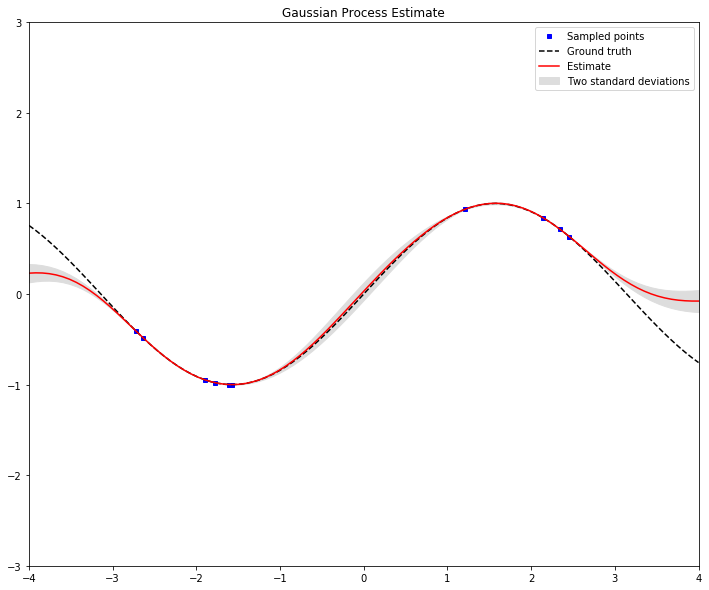

In [15]:
plot_variance(gp, x.get_value(), y.get_value())